# Assignment1 - One layer netweok multiple class image classifier

In [ ]:
%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy.special import softmax

from IPython.core.debugger import set_trace

In [46]:
LABELS = 10
IMAGE_DIMENSION = 3072
plt.rcParams['figure.figsize'] = (14.0, 8.0)

In [47]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [69]:
def load_batch(batch):
    data = unpickle('dataset/'+batch)
    # image data N*3027
    X = np.divide(data[b'data'],255)
    # labels array len 10000
    y = np.array(data[b'labels'])
    # one hot labels
    label_encoder = preprocessing.LabelBinarizer()
    label_encoder.fit(np.arange(10))
    Y = label_encoder.transform(data[b'labels'])
    return np.transpose(X), np.transpose(Y), y

In [49]:
def init_model():
    np.random.seed(400)
    mu, sigma = 0, 0.01 # mean and standard deviation
    w = np.random.normal(mu, sigma, (LABELS, IMAGE_DIMENSION))
    b = np.random.normal(mu, sigma, (LABELS, 1))
    return w, b

In [50]:
def evaluateClassifier(X, W, b):
    P = np.dot(W, X) + b #p (10, 20) (labels, images in mini_batch)
    return np.apply_along_axis(softmax, 0, P);

In [51]:
def compute_cost(X, Y, W, b, l=0):
    P = evaluateClassifier(X, W, b)
    # P (10, 20), Y (10, 20)
    E = np.multiply(P, Y) # Peform element wise multiplication
    L = np.apply_along_axis(lambda column: -np.log(np.sum(column)), 0, E) # sum each column and apploy loss func
    return np.sum(L) / L.size + l * np.power(W, 2).sum()

In [52]:
def compute_accuracy(X, y, W, b):
    P = evaluateClassifier(X, W, b)
    predictions = np.argmax(P, axis=0)
    return np.sum(predictions == y) / y.shape[0]

In [53]:
def compute_gradients(X, Y, P, W, b, l=0):
    gw = np.zeros_like(W)
    gb = np.zeros_like(b)
    
    for i in range(P.shape[1]):
        xcol = X[:,i]
        pcol = P[:,i]
        ycol = Y[:,i]
        
        g = -np.dot(ycol, np.diag(pcol) - np.outer(pcol,pcol)) / np.dot(ycol,pcol)
        gw += np.outer(g, xcol)
        gb += np.reshape(g, gb.shape)
        
    gb = gb / P.shape[1]
    gw = gw / P.shape[1] + 2*l*W
    return gw, gb       

In [54]:
def compute_grds_num(X, Y, W, b, l=0):
    h = 1e-6
    
    gw = np.zeros_like(W)
    gb = np.zeros_like(b)
    
    c = compute_cost(X, Y, W, b, l)
    for i in range(b.shape[0]):
        b_try = np.copy(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, l)
        gb[i] = (c2 - c) / h
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] += h
            c2 = compute_cost(X, Y, W, b, l)
            gw[i,j] = (c2 - c) / h
            W[i,j] -= h #reset
    return gw, gb

In [55]:
def gradient_check():
    w, b = init_model() # w(10, 3072)
    X, Y, y = load_batch('data_batch_1') # X(3072, 10000) # Y (10, 10000)

    mini_batch = X[:, 0:100] #mini_batch (3072,100)
    ground_truth = Y[:,0:100]
    P = evaluateClassifier(mini_batch, w, b) # a(100,20)
    
    gw, gb = compute_gradients(mini_batch, ground_truth, P, w, b)
    gw_n, gb_n = compute_grds_num(mini_batch, ground_truth, w, b)

    print('Gradient W:')
    print('- sum of total differences: {:.3e}'.format(np.abs(gw - gw_n).sum()))
    print('- mean W: {:.3e}   W_num: {:.3e}'
          .format(np.abs(gw).mean(), np.abs(gw_n).mean()))
    print('- min W: {:.3e}   W_num: {:.3e}'
          .format(np.abs(gw).min(),  np.abs(gw_n).min()))
    print('- max W: {:.3e}   W_num: {:.3e}'
          .format(np.abs(gw).max(),  np.abs(gw_n).max()))
    print('Gradient b:')
    print('- sum of total differences: {:.3e}'.format(np.abs(gb - gb_n).sum()))
    print('- mean b: {:.3e}   b_num: {:.3e}'
          .format(np.abs(gb).mean(), np.abs(gb_n).mean()))
    print('- min b: {:.3e}   b_num: {:.3e}'
          .format(np.abs(gb).min(),  np.abs(gb_n).min()))
    print('- max b: {:.3e}   b_num: {:.3e}'
          .format(np.abs(gb).max(),  np.abs(gb_n).max()))

In [56]:
gradient_check()

Gradient W:
- sum of total differences: 3.434e-04
- mean W: 1.534e-02   W_num: 1.534e-02
- min W: 2.215e-06   W_num: 2.205e-06
- max W: 4.678e-02   W_num: 4.678e-02
Gradient b:
- sum of total differences: 4.428e-07
- mean b: 3.429e-02   b_num: 3.429e-02
- min b: 4.782e-03   b_num: 4.781e-03
- max b: 5.592e-02   b_num: 5.592e-02


In [66]:
def train(training_set, validation_set, **gdparams):
    # training dataset
    X, Y, y = load_batch(training_set)
    # validation dataset
    Xtest, Ytest, ytest = load_batch(validation_set)
    
    # mini-batch gradients params
    n_epochs = gdparams['n_epochs']
    batch_size = gdparams['n_batch']
    eta = gdparams['eta']
    l = gdparams['l']
    
    # init model, w, b
    w,b = init_model()
    
    # source data for ploting
    plt_data = {'ts_cost': [],'ts_accuracy':[],'vs_cost': [],'vs_accuracy':[]}
    for epoch in range(0, n_epochs):
        for batch_start in range(0, X.shape[1], batch_size):
            batch_end = batch_start + batch_size
            # mini-batch size: 100
            mini_batch = X[:, batch_start:batch_end]
            ground_truth = Y[:, batch_start:batch_end]
            # predictions
            P = evaluateClassifier(mini_batch, w, b)
            # gradients of w,b
            gw, gb = compute_gradients(mini_batch, ground_truth, P, w, b, l)
            w = w - eta * gw
            b = b - eta * gb
            
        ts_cost = compute_cost(X, Y, w, b, l)
        ts_accuracy = compute_accuracy(X, y, w, b)
        
        vs_cost = compute_cost(Xtest, Ytest, w, b, l)
        vs_accuracy = compute_accuracy(Xtest, ytest, w, b)

        plt_data['ts_cost'].append(ts_cost)
        plt_data['ts_accuracy'].append(ts_accuracy)
        
        plt_data['vs_cost'].append(vs_cost)
        plt_data['vs_accuracy'].append(vs_accuracy)
#         print('cost {:f}, accuracy {:f}'.format(vs_cost, vs_accuracy))

    return w, b, plt_data

In [58]:
def plot_cost_accuracy(epochs, **plt_data):
    epochs_arr = np.arange(0, epochs).tolist()
    # Cost
    plt.subplot(1,2,1)
    plt.title('Cost')
    plt.plot(epochs_arr, plt_data['ts_cost'], 'r-',label='training set')
    plt.plot(epochs_arr, plt_data['vs_cost'], 'b-',label='validation set')
    plt.legend(loc='upper center', shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # Accuracy
    plt.subplot(1,2,2)
    plt.title('Accuracy')
    plt.plot(epochs_arr, plt_data['ts_accuracy'], 'r-',label='training set')
    plt.plot(epochs_arr, plt_data['vs_accuracy'], 'b-',label='validation set')
    plt.legend(loc='upper center', shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.show()

In [59]:
def plot_w(W):
    fig, axes = plt.subplots(1, 10)
    for coef, ax in zip(W, axes.ravel()):
        im = coef.reshape(3,32,32)
        im = (im - im.min()) / (im.max() - im.min())
        im = im.T
        im = np.rot90(im,k=3)
        ax.imshow(im)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Experiments

**Experiment 1**: `n_epochs=40, n_batch = 100,l = 0, eta = 0.1`

cost 11.530203, accuracy 0.139100


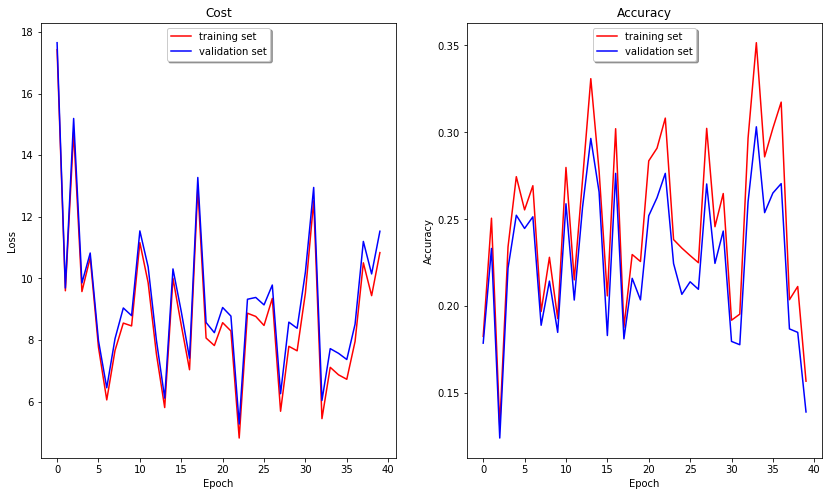

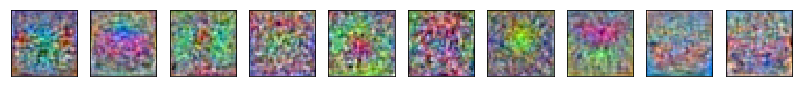

In [61]:
w, b, plt_data = train('data_batch_1', 'test_batch', n_epochs=40, n_batch = 100,l = 0, eta = 0.1)
print('cost {:f}, accuracy {:f}'.format(plt_data['vs_cost'][-1], plt_data['vs_accuracy'][-1]))
plot_cost_accuracy(40, **plt_data)
plot_w(w)

**Experiment 2**: `n_epochs=40, n_batch = 100, l = 0, eta = 0.01`

cost 1.798412, accuracy 0.368400


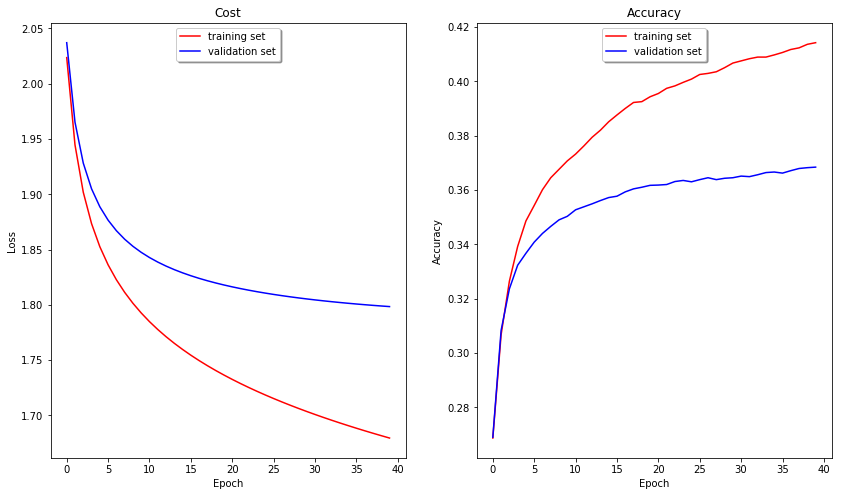

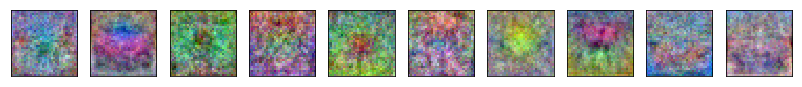

In [63]:
w, b, plt_data = train('data_batch_1', 'test_batch', n_epochs=40, n_batch = 100, l = 0, eta = 0.01)
print('cost {:f}, accuracy {:f}'.format(plt_data['vs_cost'][-1], plt_data['vs_accuracy'][-1]))
plot_cost_accuracy(40, **plt_data)
plot_w(w)

**Experiment 3**: `n_epochs=40, n_batch = 100, l = 0.1, eta = 0.01`

cost 2.013972, accuracy 0.333700


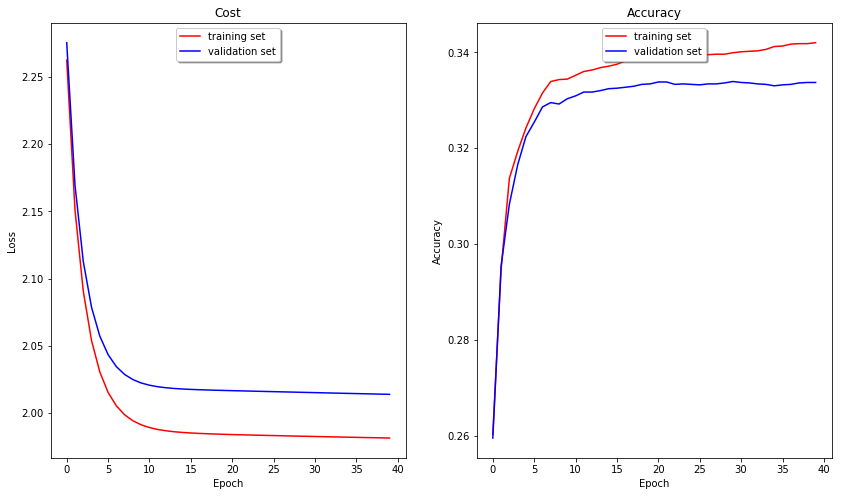

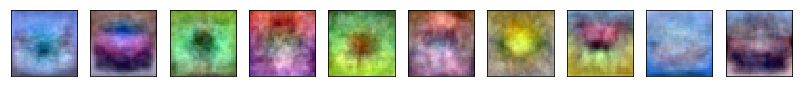

In [67]:
w, b, plt_data = train('data_batch_1', 'test_batch', n_epochs=40, n_batch = 100, l = 0.1, eta = 0.01)
print('cost {:f}, accuracy {:f}'.format(plt_data['vs_cost'][-1], plt_data['vs_accuracy'][-1]))
plot_cost_accuracy(40, **plt_data)
plot_w(w)

**Experiment 4**: `n_epochs=40, n_batch = 100, l = 1, eta = 0.01`

cost 2.205133, accuracy 0.219400


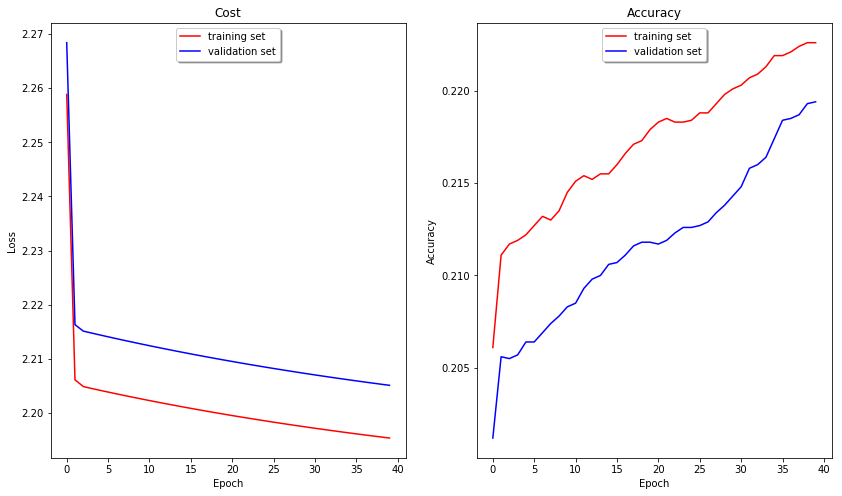

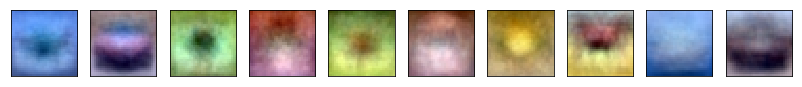

In [68]:
w, b, plt_data = train('data_batch_1', 'test_batch', n_epochs=40, n_batch = 100, l = 1, eta = 0.01)
print('cost {:f}, accuracy {:f}'.format(plt_data['vs_cost'][-1], plt_data['vs_accuracy'][-1]))
plot_cost_accuracy(40, **plt_data)
plot_w(w)

# Summary

The table below shows the cost and accuracy with different parameters applied to training process.

| # | n_epochs           | n_batch           | eta  | lambda | cost      | accuracy |
| - | ------------------ | ----------------- | ---- | ------ | --------- | -------- |
| 1 | 40                 | 100               | 0.1  | 0      | 11.530203 | 0.139100 |
| 2 | 40                 | 100               | 0.01 | 0      | 1.798412  | 0.368400 |
| 3 | 40                 | 100               | 0.01 | 0.1    | 2.013972  | 0.333700 |
| 4 | 40                 | 100               | 0.01 | 1.0    | 2.205133  | 0.219400 |

Impacts of regulation and learning rate:
- computing gradients with regulation reduces the cost/accuracy grap between training and validation set.
- Increasing learning rate result in faster convergence of loss function but impacts the test accuracy. 
